# Transformer Code Review

## Library

In [114]:
!pip install torchtext==0.6.0

In [196]:
import csv
import math
import time
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import spacy
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import seaborn as sns
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from torchtext.data import Field, BucketIterator,Example, Dataset
from torchtext.data.metrics import bleu_score
import spacy

## Dataset

In [116]:
# !git clone https://github.com/multi30k/dataset.git

In [117]:
!file /content/train.en

/content/train.en: ASCII text


In [204]:
# ASCII 텍스트 파일에서 일부 문장만 출력
with open('./train.en', 'r') as file:
    lines = file.readlines()
    num_sentences = 5

    for line in lines[:num_sentences]:
        print(line.strip())

Two young, White males are outside near many bushes.
Several men in hard hats are operating a giant pulley system.
A little girl climbing into a wooden playhouse.
A man in a blue shirt is standing on a ladder cleaning a window.
Two men are at the stove preparing food.


In [202]:
# ASCII 텍스트 파일에서 일부 문장만 출력
with open('./train.de', 'r') as file:
    lines = file.readlines()
    num_sentences = 5

    for line in lines[:num_sentences]:
        print(line.strip())

Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.
Ein kleines Mädchen klettert in ein Spielhaus aus Holz.
Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.
Zwei Männer stehen am Herd und bereiten Essen zu.


### Train dataset

In [120]:
# 영어와 독일어 파일 경로
en_file = './train.en'
de_file = './train.de'

# 두 파일을 열고 대응되는 문장 쌍을 묶기
with open(en_file, 'r', encoding='utf-8') as en_f, open(de_file, 'r', encoding='utf-8') as de_f:
    en_sentences = en_f.readlines()  # 영어 문장들
    de_sentences = de_f.readlines()  # 독일어 문장들

# 문장 쌍 묶기
dataset = [(en.strip(), de.strip()) for en, de in zip(en_sentences, de_sentences)]

# 데이터셋 확인
for en, de in dataset[:5]:  # 예시로 처음 5개의 문장 쌍 출력
    print(f'English: {en}\nGerman: {de}\n')

English: Two young, White males are outside near many bushes.
German: Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.

English: Several men in hard hats are operating a giant pulley system.
German: Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.

English: A little girl climbing into a wooden playhouse.
German: Ein kleines Mädchen klettert in ein Spielhaus aus Holz.

English: A man in a blue shirt is standing on a ladder cleaning a window.
German: Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.

English: Two men are at the stove preparing food.
German: Zwei Männer stehen am Herd und bereiten Essen zu.



In [121]:
import csv

# 데이터셋을 CSV 파일로 저장
with open('./train_dataset.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['English', 'German'])  # 헤더
    writer.writerows(dataset)  # 데이터 쓰기

### Validation dataset

In [122]:
en_file = './val.en'
de_file = './val.de'

with open(en_file, 'r', encoding='utf-8') as en_f, open(de_file, 'r', encoding='utf-8') as de_f:
    en_sentences = en_f.readlines()  # 영어 문장들
    de_sentences = de_f.readlines()  # 독일어 문장들

dataset = [(en.strip(), de.strip()) for en, de in zip(en_sentences, de_sentences)]

for en, de in dataset[:5]:  # 예시로 처음 5개의 문장 쌍 출력
    print(f'English: {en}\nGerman: {de}\n')

with open('./validation_dataset.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['English', 'German'])  # 헤더
    writer.writerows(dataset)  # 데이터 쓰기

English: A group of men are loading cotton onto a truck
German: Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen

English: A man sleeping in a green room on a couch.
German: Ein Mann schläft in einem grünen Raum auf einem Sofa.

English: A boy wearing headphones sits on a woman's shoulders.
German: Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.

English: Two men setting up a blue ice fishing hut on an iced over lake
German: Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf

English: A balding man wearing a red life jacket is sitting in a small boat.
German: Ein Mann mit beginnender Glatze, der eine rote Rettungsweste trägt, sitzt in einem kleinen Boot.



In [123]:
en_file = './test_2016_flickr.en'
de_file = './test_2016_flickr.de'

with open(en_file, 'r', encoding='utf-8') as en_f, open(de_file, 'r', encoding='utf-8') as de_f:
    en_sentences = en_f.readlines()  # 영어 문장들
    de_sentences = de_f.readlines()  # 독일어 문장들

dataset = [(en.strip(), de.strip()) for en, de in zip(en_sentences, de_sentences)]

for en, de in dataset[:5]:  # 예시로 처음 5개의 문장 쌍 출력
    print(f'English: {en}\nGerman: {de}\n')

with open('./test2016flickr_dataset.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['English', 'German'])  # 헤더
    writer.writerows(dataset)  # 데이터 쓰기

English: A man in an orange hat starring at something.
German: Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.

English: A Boston Terrier is running on lush green grass in front of a white fence.
German: Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.

English: A girl in karate uniform breaking a stick with a front kick.
German: Ein Mädchen in einem Karateanzug bricht ein Brett mit einem Tritt.

English: Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.
German: Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.

English: People are fixing the roof of a house.
German: Leute Reparieren das Dach eines Hauses.



In [124]:
train_dataset = pd.read_csv('./train_dataset.csv')
validation_dataset = pd.read_csv('./validation_dataset.csv')
test_dataset = pd.read_csv('./test2016flickr_dataset.csv')

In [125]:
train_dataset.head()

,English,German
0,"Two young, White males are outside near many b...",Zwei junge weiße Männer sind im Freien in der ...
1,Several men in hard hats are operating a giant...,Mehrere Männer mit Schutzhelmen bedienen ein A...
2,A little girl climbing into a wooden playhouse.,Ein kleines Mädchen klettert in ein Spielhaus ...
3,A man in a blue shirt is standing on a ladder ...,Ein Mann in einem blauen Hemd steht auf einer ...
4,Two men are at the stove preparing food.,Zwei Männer stehen am Herd und bereiten Essen zu.


In [126]:
validation_dataset.head()

,English,German
0,A group of men are loading cotton onto a truck,Eine Gruppe von Männern lädt Baumwolle auf ein...
1,A man sleeping in a green room on a couch.,Ein Mann schläft in einem grünen Raum auf eine...
2,A boy wearing headphones sits on a woman's sho...,Ein Junge mit Kopfhörern sitzt auf den Schulte...
3,Two men setting up a blue ice fishing hut on a...,Zwei Männer bauen eine blaue Eisfischerhütte a...
4,A balding man wearing a red life jacket is sit...,"Ein Mann mit beginnender Glatze, der eine rote..."


In [127]:
test_dataset.head()

,English,German
0,A man in an orange hat starring at something.,"Ein Mann mit einem orangefarbenen Hut, der etw..."
1,A Boston Terrier is running on lush green gras...,Ein Boston Terrier läuft über saftig-grünes Gr...
2,A girl in karate uniform breaking a stick with...,Ein Mädchen in einem Karateanzug bricht ein Br...
3,Five people wearing winter jackets and helmets...,Fünf Leute in Winterjacken und mit Helmen steh...
4,People are fixing the roof of a house.,Leute Reparieren das Dach eines Hauses.


In [128]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(validation_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


### Data Preprocessing

In [129]:
def tokenize(sentence):
  return sentence.lower().split()

In [130]:
train_data = [(tokenize(src), tokenize(trg)) for src, trg in zip(train_dataset['English'], train_dataset['German'])]
validation_data = [(tokenize(src), tokenize(trg)) for src, trg in zip(validation_dataset['English'], validation_dataset['German'])]
test_data = [(tokenize(src), tokenize(trg)) for src, trg in zip(test_dataset['English'], test_dataset['German'])]

In [131]:
train_data[0]

(['two',
  'young,',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes.'],
 ['zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche.'])

In [132]:
test_data[0]

(['a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck'],
 ['eine',
  'gruppe',
  'von',
  'männern',
  'lädt',
  'baumwolle',
  'auf',
  'einen',
  'lastwagen'])

In [133]:
# 독일어(Deutsch) 문장을 토큰화 하는 함수 (순서를 뒤집지 않음)
def tokenize_de(text):
    return [token.text for token in text]

# 영어(English) 문장을 토큰화 하는 함수
def tokenize_en(text):
    return [token.text for token in text]

In [134]:
train_data[0]

(['two',
  'young,',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes.'],
 ['zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche.'])

In [135]:
SRC = Field(tokenize=tokenize_de, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)
TRG = Field(tokenize=tokenize_en, init_token="<sos", eos_token="<eos>", lower=True, batch_first=True)
train_examples = [Example.fromlist([src, trg], fields=[('src', SRC), ('trg', TRG)]) for trg, src in train_data]
train_dataset = Dataset(train_examples, fields={'src': SRC, 'trg': TRG})

SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

In [136]:
print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 9597
len(TRG): 7704


In [137]:
SRC.vocab.itos[:10]

['<unk>',
 '<pad>',
 '<sos>',
 '<eos>',
 'ein',
 'einem',
 'in',
 'eine',
 'und',
 'mit']

In [138]:
TRG.vocab.itos[:10]

['<unk>', '<pad>', '<sos', '<eos>', 'a', 'in', 'the', 'on', 'man', 'is']

In [139]:
print(TRG.vocab.stoi["abcabc"])
print(TRG.vocab.stoi[TRG.pad_token])
print(TRG.vocab.stoi[""])
print(TRG.vocab.stoi[""])
print(TRG.vocab.stoi["hello"])
print(TRG.vocab.stoi["world"])

0
1
0
0
5039
2798


In [140]:
len(train_examples)

29000

In [141]:
validation_examples = [Example.fromlist([src, trg], fields=[('src', SRC), ('trg', TRG)]) for trg, src in validation_data]
validation_dataset = Dataset(validation_examples, fields={'src': SRC, 'trg': TRG})

test_examples = [Example.fromlist([src, trg], fields=[('src', SRC), ('trg', TRG)]) for trg, src in test_data]
test_dataset = Dataset(test_examples, fields={'src': SRC, 'trg': TRG})

# Dataset 내용 확인
print("Validation Dataset 크기:", len(validation_dataset))
print("Test Dataset 크기:", len(test_dataset))

# 첫 번째 예시 데이터 확인
print("Validation 데이터 첫 번째 예시의 src:", validation_dataset[0].src)
print("Validation 데이터 첫 번째 예시의 tgt:", validation_dataset[0].trg)
print("Test 데이터 첫 번째 예시의 src:", test_dataset[0].src)

Validation Dataset 크기: 1014
Test Dataset 크기: 1014
Validation 데이터 첫 번째 예시의 src: ['eine', 'gruppe', 'von', 'männern', 'lädt', 'baumwolle', 'auf', 'einen', 'lastwagen']
Validation 데이터 첫 번째 예시의 tgt: ['a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck']
Test 데이터 첫 번째 예시의 src: ['eine', 'gruppe', 'von', 'männern', 'lädt', 'baumwolle', 'auf', 'einen', 'lastwagen']


In [142]:
def sort_key(ex):
  return len(ex.src)

In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, validation_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=sort_key
)

In [144]:
for i, batch in enumerate(train_iterator):
  src = batch.src
  trg = batch.trg

  print(f"First batch of src size: {src.shape}")
  print(f"First batch of trg size: {trg.shape}")

  for i in range(src.shape[1]):
    print(f"index {i}: {src[0][i].item()}")

  break

First batch of src size: torch.Size([128, 25])
First batch of trg size: torch.Size([128, 26])
index 0: 2
index 1: 28
index 2: 6
index 3: 150
index 4: 732
index 5: 9
index 6: 0
index 7: 2833
index 8: 142
index 9: 17
index 10: 6248
index 11: 74
index 12: 3
index 13: 1
index 14: 1
index 15: 1
index 16: 1
index 17: 1
index 18: 1
index 19: 1
index 20: 1
index 21: 1
index 22: 1
index 23: 1
index 24: 1


## Model Define

### Multi Head Attention

In [145]:
class MultiHeadAttentionLayer(nn.Module):
  def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
    super().__init__()

    assert hidden_dim % n_heads == 0

    self.hidden_dim = hidden_dim
    self.n_heads = n_heads
    self.head_dim = hidden_dim // n_heads

    self.fc_q = nn.Linear(hidden_dim, hidden_dim)
    self.fc_k = nn.Linear(hidden_dim, hidden_dim)
    self.fc_v = nn.Linear(hidden_dim, hidden_dim)

    self.fc_o = nn.Linear(hidden_dim, hidden_dim)

    self.dropout = nn.Dropout(dropout_ratio)

    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

  def forward(self, query, key, value, mask = None):
    batch_size = query.shape[0]

    # query: [batch_size, query_len, hidden_dim]
    # key: [batch_size, key_len, hidden_dim]
    # value: [batch_size, value_len, hidden_dim]

    Q = self.fc_q(query)
    K = self.fc_k(key)
    V = self.fc_v(value)
    # Q: [batch_size, query_len, hidden_dim]
    # K: [batch_size, key_len, hidden_dim]
    # V: [batch_size, value_len, hidden_dim]

    # hidden_dim -> n_heads x head_dim
    # n_heads개의 서로 다른 attention 컨셉을 학습하도록
    Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    # (batch_size, seq_len, hidden_dim) -> (batch_size, seq_len, n_heads, head_dim) -> (batch_size, n_heads, seq_len, head_dim)
    # Q: [batch_size, n_heads, query_len, head_dim]
    # K: [batch_size, n_heads, key_len, head_dim]
    # V: [batch_size, n_heads, value_len, head_dim]

    # Attention Energy 계산
    energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
    # energy: [batch_size, n_heads, query_len, key_len]

    # mask를 사용하는 경우
    if mask is not None:
      # mask 값이 0인 부분을 -1e10으로 채우기
      energy = energy.masked_fill(mask == 0, -1e10)

    # attention score 계산
    attention = torch.softmax(energy, dim = -1)
    # attention: [batch_size, n_heads, query_len, key_len]

    # scaeld dot-product attention 계산
    x = torch.matmul(self.dropout(attention), V)
    # x: [batch_size, n_heads, query_len, head_dim]

    x = x.permute(0, 2, 1, 3).contiguous()
    # x: [batch_size, query_len, n_heads, head_dim]

    x = x.view(batch_size, -1, self.hidden_dim)
    # x: [batch_size, query_len, hidden_dim]

    x = self.fc_o(x)
    # x: [batch_size, query_len, hidden_dim]

    return x, attention

꼭 (batch_size, seq_len, n_heads, head_dim)에서 (batch_size, n_heads, seq_len, head_dim)로 변환해야 하는 이유는 어텐션 계산의 효율성을 높이기 위해서입니다. 다중 헤드 어텐션에서는 각 헤드가 독립적으로 문맥 정보를 학습해야 하므로, 모든 헤드의 어텐션을 병렬로 계산할 수 있도록 차원 순서를 재배열해야 합니다.

이유: 차원 순서 변환의 필요성

	1.	독립적인 어텐션 계산:
	•	(batch_size, seq_len, n_heads, head_dim) 형식에서는 어텐션을 계산할 때 헤드별 독립적인 연산이 어렵습니다.
	•	반드시 n_heads 차원이 두 번째로 위치해야 각 헤드에 대해 병렬 계산이 가능해집니다. n_heads 차원이 두 번째에 위치하면 각 헤드를 따로 떼어내어 병렬 연산을 효율적으로 수행할 수 있습니다.
	2.	병렬 연산 최적화:
	•	(batch_size, n_heads, seq_len, head_dim) 형식은 PyTorch와 같은 프레임워크에서 배치 행렬 곱셈(bmm) 연산을 사용하기에 최적화된 구조입니다.
	•	bmm 연산은 (batch_size * n_heads, seq_len, head_dim) 형식으로 데이터를 전달할 때 병렬 처리가 가능하도록 설계되었습니다. 이처럼 헤드별로 독립적인 어텐션 가중치를 계산하는 데 최적화된 형식이므로, 변환을 통해 연산 속도가 크게 향상됩니다.
	3.	어텐션 가중치 행렬(Q, K, V)의 효율적 사용:
	•	어텐션 계산에서 Q, K, V 행렬이 각각의 헤드에 맞게 분할되어 사용됩니다.
	•	각 헤드가 독립적으로 Q, K, V를 사용하여 어텐션 스코어를 계산하기 때문에, (batch_size, n_heads, seq_len, head_dim) 형식이 모든 헤드의 어텐션을 동시에 계산하기에 최적의 구조입니다.

요약

	•	독립적이고 효율적인 병렬 연산: 각 헤드가 독립적으로 어텐션을 계산하기 위해 차원 순서가 필요합니다.
	•	프레임워크 최적화: PyTorch의 bmm와 같은 연산이 n_heads가 두 번째 차원에 위치한 형식에서 가장 효과적으로 작동합니다.

따라서 (batch_size, seq_len, n_heads, head_dim)에서 (batch_size, n_heads, seq_len, head_dim)로 변환하는 것은 다중 헤드 어텐션의 병렬 처리와 최적화된 계산을 위해 필수적입니다.

### Point-wise Feedforward

In [146]:
class PositionwiseFeedforwardLayer(nn.Module):
  def __init__(self, hidden_dim, pf_dim, dropout_ratio):
    super().__init__()

    self.fc_1 = nn.Linear(hidden_dim, pf_dim)
    self.fc_2 = nn.Linear(pf_dim, hidden_dim)

    self.dropout = nn.Dropout(dropout_ratio)

  def forward(self, x):
    # x: [batch_size, seq_len, hidden_dim]

    x = self.dropout(torch.relu(self.fc_1(x)))
    # x: [batch_size, seq_len, pf_dim]

    x = self.fc_2(x)
    # x: [batch_size, seq_len, hidden_dim]

    return x

### Encoder layer

In [147]:
class EncoderLayer(nn.Module):
  def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
    super().__init__()

    self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
    self.ff_layer_norm = nn.LayerNorm(hidden_dim)
    self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
    self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
    self.dropout = nn.Dropout(dropout_ratio)

  # 하나의 embedding이 복제되어 q, k, v로 입력되는 방식
  def forward(self, src, src_mask):
    # src: [batch_size, src_len, hidden_dim]
    # src_mask: [batch_size, src_len]

    # self attention
    _src, _ = self.self_attention(src, src, src, src_mask)

    # dropout, residual connection and layer norm
    src = self.self_attn_layer_norm(src + self.dropout(_src))
    # src: [batch_size, src_len, hidden_dim]

    # position-wise feedforward
    _src = self.positionwise_feedforward(src)

    # dropout, residual connection and layer norm
    src = self.ff_layer_norm(src + self.dropout(_src))
    # src: [batch_size, src_len, hidden_dim]

    return src

### Encoder

"원본 논문과는 다르게 위치 임베딩(positional embedding)을 학습하는 형태로 구현합니다." -> 이 부분은 추후에 원본처럼 포지셔널 임베딩 구현해보기

In [148]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length = 100):
    super().__init__()

    self.device = device

    self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
    self.pos_embedding = nn.Embedding(max_length, hidden_dim)

    self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

    self.dropout = nn.Dropout(dropout_ratio)
    self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

  def forward(self, src, src_mask):
    # src: [batch_size, src_len]
    # src_mask: [batch_size, src_len]

    batch_size = src.shape[0]
    src_len = src.shape[1]

    pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
    # pos: [batch_size, src_len]

    src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
    # src: [batch_size, src_len, hidden_dim]

    # forward in all encoder layer
    for layer in self.layers:
      src = layer(src, src_mask)
    # src: [batch_size, src_len, hidden_dim]

    return src

### Decoder Layer

In [149]:
class DecoderLayer(nn.Module):
  def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
    super().__init__()

    self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
    self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
    self.ff_layer_norm = nn.LayerNorm(hidden_dim)
    self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
    self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
    self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
    self.dropout = nn.Dropout(dropout_ratio)

  # encoder의 output(enc_src)을 attention
  def forward(self, trg, enc_src, trg_mask, src_mask):
    # trg: [batch_size, trg_len, hidden_dim]
    # eng_src: [batch_size, src_len, hidden_dim]
    # trg_mask: [batch_size, trg_len]
    # src_mask: [batch_size, src_len]

    # self attention
    _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

    # dropout, residual connection and layer norm
    trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
    # trg: [batch_size, trg_len, hidden_dim]

    # encoder attention
    # decoder의 query를 이용해 encoder를 attention
    _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

    # dropout, residual connection and layer norm
    trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
    # trg: [batch_size, trg_len, hidden_dim]

    # positionwise feedforward
    _trg = self.positionwise_feedforward(trg)

    # dropout, residual connection and layernorm
    trg = self.ff_layer_norm(trg + self.dropout(_trg))
    # trg: [batch_size, trg_len, hidden_dim]
    # attention: [batch_size, n_heads, trg_len, src_len]

    return trg, attention

### Decoder

In [150]:
class Decoder(nn.Module):
  def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length = 100):
    super().__init__()

    self.device = device

    self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
    self.pos_embedding = nn.Embedding(max_length, hidden_dim)

    self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

    self.fc_out = nn.Linear(hidden_dim, output_dim)

    self.dropout = nn.Dropout(dropout_ratio)

    self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

  def forward(self, trg, enc_src, trg_mask, src_mask):
    # trg: [batch_size, trg_len]
    # enc_src: [batch_size, src_len, hidde_dim]
    # trg_mask: [batch_size, trg_len]
    # src_mask: [batch_size, src_len]

    batch_size = trg.shape[0]
    trg_len = trg.shape[1]

    pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
    # pos: [batch_size, trg_len]

    trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
    # trg: [batch_size, trg_len, hidden_dim]

    for layer in self.layers:
      trg, attention = layer(trg, enc_src, trg_mask, src_mask)
      # trg: [batch_size, trg_len, hidden_dim]
      # attention: [batch_size, n_heads, trg_len, src_len]

    output = self.fc_out(trg)
    # output: [batch_size, trg_len, output_dim]

    return output, attention


### Transformer

In [151]:
class Transformer(nn.Module):
  def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  def make_src_mask(self, src):
    # src: [batch_size, src_len]

    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    # src_mask: [batch_size, 1, 1, src_len]

    return src_mask

  # 각 단어가 다음 단어가 무엇인지 알 수 없도록 마스킹
  def make_trg_mask(self, trg):
    # trg: [batch_size, trg_len]


    """mask exmaple
    1 0 0 0 0
    1 1 0 0 0
    1 1 1 0 0
    1 1 1 0 0
    1 1 1 0 1
    """
    # sequence길이를 맞추기 위해 padding된 부분을 무시하기 위함
    trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
    # trg_pad_mask: [batch_size, 1, 1, trg_len]

    trg_len = trg.shape[1]

    """mask exmaple
    1 0 0 0 0
    1 1 0 0 0
    1 1 1 0 0
    1 1 1 1 0
    1 1 1 1 1
    """
    # 미래 단어를 참조하지 않도록 하기 위함
    trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
    # trg_sub_mask: [trg_len, trg_len]

    trg_mask = trg_pad_mask & trg_sub_mask
    # trg_mask: [batch_size, 1, trg_len, trg_len]

    return trg_mask

  def forward(self, src, trg):
    # src: [batch_size, src_len]
    # trg: [batch_size, trg_len]

    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)
    # src_mask: [batch_size, 1, 1, src_len]
    # trg_mask: [batch_size, 1, trg_len, trg_len]

    enc_src = self.encoder(src, src_mask)
    # enc_src: [batch_size, src_len, hidden_dim]

    output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
    # output: [batch_size, trg_len, output_dim]
    # attention: [batch_size, n_heads, trg_len, src_len]

    return output, attention

## Train

### config

In [152]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [153]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [154]:
model

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(9597, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
     

In [155]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,413,848 trainable parameters


In [156]:
def initialize_weights(m):
  if hasattr(m, 'weight') and m.weight.dim() > 1:
    nn.init.xavier_uniform_(m.weight.data)

In [157]:
LEARNING_RATE = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 padding에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [158]:
def train(model, iterator, optimizer, criterion, clip):
  model.train()
  epoch_loss = 0

  for i, batch in enumerate(iterator):
    src = batch.src
    trg = batch.trg

    optimizer.zero_grad()

    output, _ = model(src, trg[:,:-1])
    # output: [batch_size, trg_len - 1, output_dim]
    # trg: [batch_size, trg_len]

    output_dim = output.shape[-1]

    output = output.contiguous().view(-1, output_dim)

    trg = trg[:,1:].contiguous().view(-1)
    # output: [batch_size * (trg_len - 1), output_dim]
    # trg: [batch_size * (trg_len - 1)]

    loss = criterion(output, trg)
    loss.backward()

    # gradient clipping to prevent gradient sharp change
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()

    epoch_loss += loss.item()

  return epoch_loss / len(iterator)

In [159]:
def evaluate(model, iterator, criterion):
  model.eval()
  epoch_loss = 0

  with torch.no_grad():
    for i, batch in enumerate(iterator):
      src = batch.src
      trg = batch.trg

      output, _ = model(src, trg[:,:-1])
      # output: [batch_size, trg_len - 1, output_dim]
      # trg: [batch_size, trg_len]

      output_dim = output.shape[-1]

      output = output.contiguous().view(-1, output_dim)
      trg = trg[:,1:].contiguous().view(-1)
      # output: [batch_size * (trg_len - 1), output_dim]
      # trg: [batch_size * (trg_len - 1)]

      loss = criterion(output, trg)

      epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [160]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [161]:
N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  start_time = time.time()

  train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
  valid_loss = evaluate(model, valid_iterator, criterion)

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'transformer_german_to_english.pt')

  print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
  print(f'\tValid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 17s
	Train Loss: 4.560 | Train PPL:  95.540
	Valid Loss: 3.459 | Valid PPL:  31.779
Epoch: 02 | Time: 0m 13s
	Train Loss: 3.401 | Train PPL:  30.005
	Valid Loss: 2.947 | Valid PPL:  19.041
Epoch: 03 | Time: 0m 13s
	Train Loss: 2.953 | Train PPL:  19.173
	Valid Loss: 2.646 | Valid PPL:  14.100
Epoch: 04 | Time: 0m 13s
	Train Loss: 2.647 | Train PPL:  14.110
	Valid Loss: 2.487 | Valid PPL:  12.025
Epoch: 05 | Time: 0m 14s
	Train Loss: 2.407 | Train PPL:  11.099
	Valid Loss: 2.324 | Valid PPL:  10.212
Epoch: 06 | Time: 0m 14s
	Train Loss: 2.199 | Train PPL:   9.014
	Valid Loss: 2.239 | Valid PPL:   9.382
Epoch: 07 | Time: 0m 13s
	Train Loss: 2.024 | Train PPL:   7.572
	Valid Loss: 2.179 | Valid PPL:   8.834
Epoch: 08 | Time: 0m 13s
	Train Loss: 1.871 | Train PPL:   6.497
	Valid Loss: 2.121 | Valid PPL:   8.338
Epoch: 09 | Time: 0m 13s
	Train Loss: 1.735 | Train PPL:   5.668
	Valid Loss: 2.103 | Valid PPL:   8.187
Epoch: 10 | Time: 0m 13s
	Train Loss: 1.611 | Train PPL

In [162]:
from google.colab import files
files.download('transformer_german_to_english.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test

In [163]:
model.load_state_dict(torch.load('./transformer_german_to_english.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

<ipython-input-163-e7c6567d0869>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./transformer_german_to_english.pt'))


Test Loss: 2.102 | Test PPL: 8.186


## Translator using Transformer

In [179]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50, logging=True):
  model.eval()

  tokens = sentence

  tokens = [src_field.init_token] + tokens + [src_field.eos_token]
  if logging:
    print(f"전체 소스 토큰: {tokens}")

  src_index = [src_field.vocab.stoi[token] for token in tokens]
  if logging:
    print(f"소스 문장 인덱스: {src_index}")

  src_tensor = torch.LongTensor(src_index).unsqueeze(0).to(device)

  src_mask = model.make_src_mask(src_tensor)

  with torch.no_grad():
    enc_src = model.encoder(src_tensor, src_mask)

  trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

  for i in range(max_len):
    trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

    trg_mask = model.make_trg_mask(trg_tensor)

    with torch.no_grad():
      output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

    pred_token = output.argmax(2)[:, -1].item()
    trg_indexes.append(pred_token)

    if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
      break

  trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

  return trg_tokens[1:], attention

In [180]:
example_idx = 10

src = test_dataset.examples[example_idx].src
trg = test_dataset.examples[example_idx].trg

print(f'Source sentence: {src}')
print(f'Target sentence: {trg}')

Source sentence: ['ein', 'kleines', 'kind', 'steht', 'allein', 'auf', 'einem', 'zerklüfteten', 'felsen.']
Target sentence: ['a', 'young', 'child', 'is', 'standing', 'alone', 'on', 'some', 'jagged', 'rocks.']


In [181]:
src

['ein',
 'kleines',
 'kind',
 'steht',
 'allein',
 'auf',
 'einem',
 'zerklüfteten',
 'felsen.']

In [182]:
translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print(f'Translated sentence: {translation}')

전체 소스 토큰: ['<sos>', 'ein', 'kleines', 'kind', 'steht', 'allein', 'auf', 'einem', 'zerklüfteten', 'felsen.', '<eos>']
소스 문장 인덱스: [2, 4, 59, 50, 27, 1046, 10, 5, 0, 618, 3]
Translated sentence: ['a', 'young', 'child', 'stands', 'alone', 'on', 'a', 'rock', 'wall', 'of', '<unk>', '<eos>']


### Visualize Attention Map

In [194]:
def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

  assert n_rows * n_cols == n_heads

  fig = plt.figure(figsize=(15,25))

  for i in range(n_heads):
    ax = fig.add_subplot(n_rows, n_cols, i+1)

    _attention = attention.squeeze(0)[i].cpu().detach().numpy()

    cax = ax.matshow(_attention, cmap='bone')

    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)

    ax.tick_params(labelsize=12)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], rotation=45)
    ax.set_yticklabels(['<sos>'] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()
  plt.close()

<ipython-input-194-4b1e72dcddd4>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], rotation=45)
<ipython-input-194-4b1e72dcddd4>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['<sos>'] + translation)


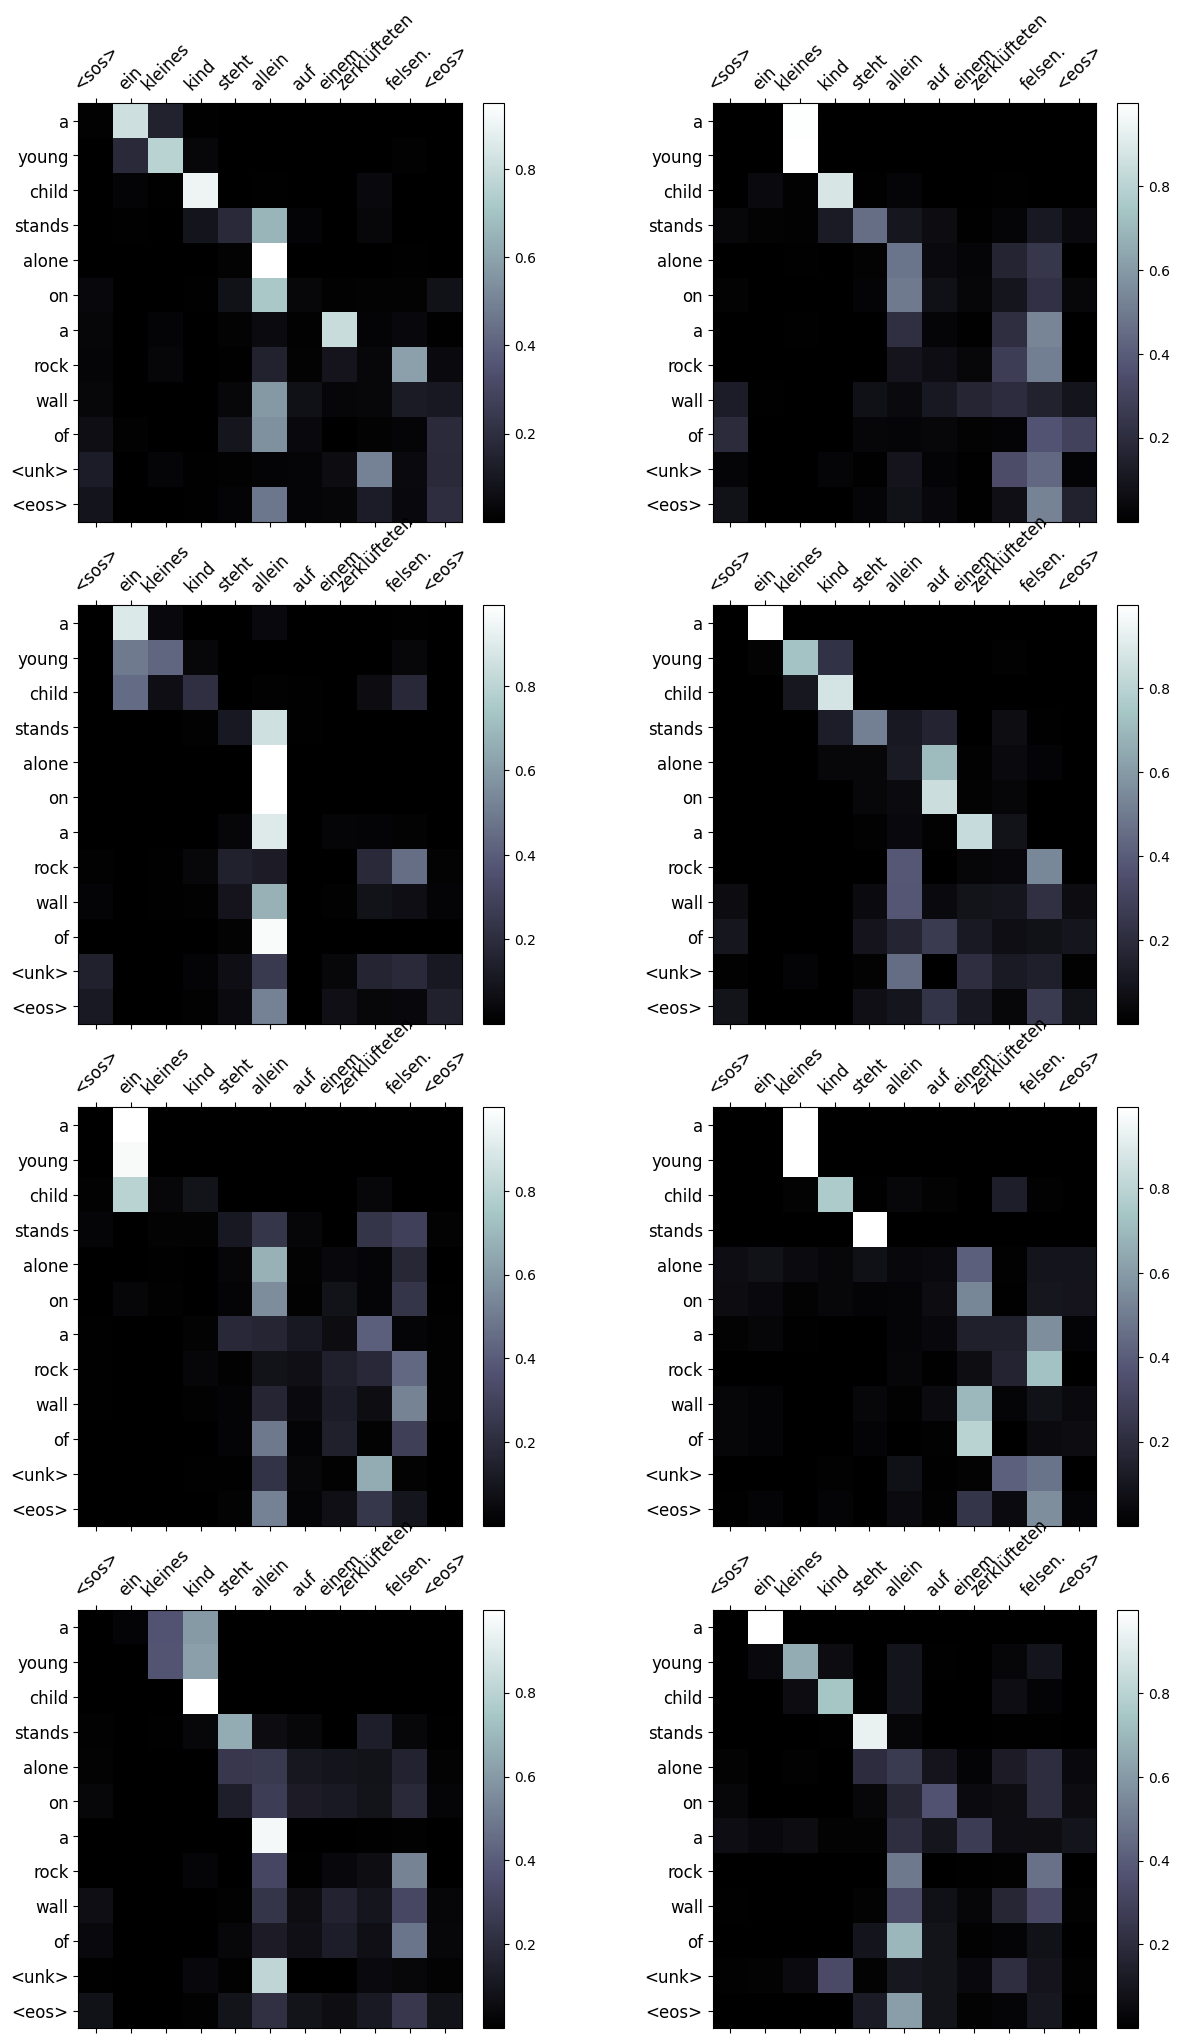

In [195]:
display_attention(src, translation, attention)

German : English
- ein : a
- kleines : young
- kind : child
- steht : stands
- allein : alone
- auf : on
- einem : one


## BLEU Score

In [199]:
def show_bleu(data, src_field, trg_field, model, device, max_len=50):
  trgs = []
  pred_trgs = []
  index = 0

  for datum in data:
    src = datum.src
    trg = datum.trg

    pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len, logging=False)

    pred_trg = pred_trg[:-1]

    pred_trgs.append(pred_trg)
    trgs.append([trg])

    index += 1
    if (index + 1) % 100 == 0:
      print(f"[{index + 1}/{len(data)}]")
      print(f"predictd sentence: {pred_trg}")
      print(f"label: {trg}")

  bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
  print(f'BLEU score = {bleu * 100:.2f}')

  individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
  individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
  individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
  individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

  print(f'Individual BLEU1 score = {individual_bleu1_score*100:.2f}')
  print(f'Individual BLEU2 score = {individual_bleu2_score*100:.2f}')
  print(f'Individual BLEU3 score = {individual_bleu3_score*100:.2f}')
  print(f'Individual BLEU4 score = {individual_bleu4_score*100:.2f}')

  cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
  cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
  cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
  cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

  print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}')
  print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}')
  print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}')
  print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}')

In [200]:
show_bleu(test_dataset, SRC, TRG, model, device)

[100/1014]
predictd sentence: ['some', 'men', 'sit', 'near', 'a', 'boat', 'with', 'a', 'boat', 'and', '<unk>', '<unk>']
label: ['some', 'men', 'are', 'sitting', 'on', 'a', 'boat', 'near', 'a', 'beach', 'covered', 'in', 'stacked', 'logs', 'and', 'sticks.']
[200/1014]
predictd sentence: ['a', 'person', 'rowing', 'in', 'their', 'boat', 'in', 'the', 'water.']
label: ['a', 'person', 'rowing', 'in', 'their', 'boat', 'in', 'the', 'water.']
[300/1014]
predictd sentence: ['boys', 'smiling', 'girl', 'and', 'girl', 'are', 'smiling', 'out', 'of', 'a', 'grassy', 'field', 'of', 'grass.']
label: ['boys', 'and', 'girls', 'from', 'an', 'eastern', 'nation', 'smiling', 'in', 'a', 'field.']
[400/1014]
predictd sentence: ['young', 'people', 'are', 'playing', 'with', 'a', 'game', 'of', 'leaves.']
label: ['young', 'people', 'are', 'engaged', 'in', 'a', 'game.']
[500/1014]
predictd sentence: ['the', 'men', 'are', 'fighting', 'while', 'the', 'men', 'watch.']
label: ['the', 'men', 'fight', 'during', 'the', 'gam